In [1]:
import sys
import os
sys.path.insert(1, '..')

import numpy as np
import scipy as sp
from scipy.fft import fft

import pandas as pd
from utils import *
import librosa

import matplotlib.pyplot as plt
import seaborn as sns

import IPython.display as ipd

/home/joao/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
ls '../dados/aligned_noises/'

signal_4_rr.wav  signal_4_ss.wav


In [4]:
signal_rr, _ = librosa.load('../dados/aligned_noises/signal_4_rr.wav', sr = None)
signal_ss, _ = librosa.load('../dados/aligned_noises/signal_4_ss.wav', sr = None)

In [5]:
# Sinal original
ipd.Audio(signal_rr, rate = 8000)

In [7]:
# Sinal com ruído reduzido
ipd.Audio(signal_ss, rate= 8000)

---
## Cria função que cria os frames com overlap

In [10]:
# Esboço da função
sr = 8e3
fram_secs = 30e-3
frame_length_samples = int(sr * fram_secs)
overlap = int(frame_length_samples / 2)

frames = librosa.util.frame(signal_rr,
                            frame_length = frame_length_samples,
                            hop_length = overlap,
                            axis = 0)

In [10]:
def frame_signal(sample_rate: int, frame_seconds: float, overlap: float, signal: np.array) -> np.array:
    """Cut signal into frames of specified length"""
    
    frame_length_samples = int(sr * frame_seconds)
    overlap = int(frame_length_samples *  overlap)
    
    frames = librosa.util.frame(signal,
                                frame_length = frame_length_samples,
                                hop_length = overlap,
                                axis = 0)
    return frames

---
## Cria função que avalia se a potencia dos sinais está parecida

In [14]:
def energy_delta(signal_ref: np.array, signal_comp: np.array) -> float:
    """Relative delta"""
    
    energy_ref = get_signal_energy(signal_ref)
    energy_comp = get_signal_energy(signal_comp)
    
    energy_diff = abs(energy_comp - energy_ref) / energy_ref
    return energy_diff

In [15]:
frames_rr = frame_signal(sample_rate = sr,
                         frame_seconds = fram_secs,
                         overlap = 0.5,
                         signal = signal_rr)

frames_ss = frame_signal(sample_rate = sr,
                         frame_seconds = fram_secs,
                         overlap = 0.5,
                         signal = signal_ss)

In [16]:
energy_delta(signal_rr, signal_ss)

0.03770186274229211

---
## Cria Funções das Métricas de Erro

### Cria Função que calcula o modulo da fft de um sinal

In [17]:
def fft_mod(signal: np.array) -> np.array:
    """Magnitude of a fft"""
    
    magnitude_spectra = abs(fft(signal))
    return magnitude_spectra

In [18]:
fft_mod(signal_rr)

array([0.8883972 , 0.03220386, 0.0355405 , ..., 0.03588647, 0.0355405 ,
       0.03220386], dtype=float32)

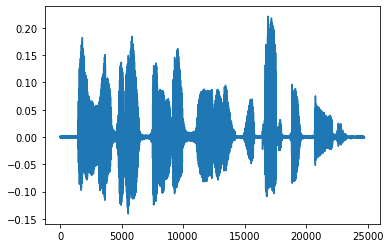

In [19]:
plt.plot(signal_rr)

### Cria função que cácula o sinal de erro absoluto entre o espectro de dois sinais

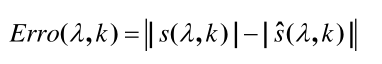

In [57]:
# No caso caso indice desse sinal seria o erro, que é o erro do bin
def spectrum_error_signal(signal_ref: np.array, signal_est: np.array) -> np.array:
    """Calculates de signal of absolute error between two spectra"""
    
    mod_ref = abs(fft_mod(signal_ref) - fft_mod(signal_est))
    return mod_ref

In [58]:
ref_espectrum = fft_mod(signal_rr)
est_espectrum = fft_mod(signal_ss)
error_signal = spectrum_error_signal(signal_rr, signal_ss)

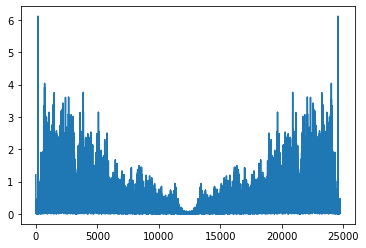

In [59]:
plt.plot(error_signal)

### Cria função que calcula o erro no frame

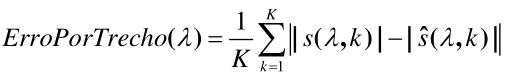

In [48]:
# Seria o erro por trecho
def error_by_frame(frames_ref: list, frames_est: list, n_frame: int) -> float:
    """Mean spectrum error of a frame"""
    
    est_frame = frames_ref[n_frame]
    ref_frame = frames_ss[n_frame]
    
    frame_length = len(ref_frame)
    frame_error = (sum(spectrum_error_signal(ref_frame, est_frame))
                   / frame_length)
    
    return frame_error

In [48]:
frame_error = error_by_frame(frames_rr, frames_ss, 1)
print(f'Frame error: {frame_error:.2f}')

Frame error: 0.02


### Cria função que calcula o erro no bin (indice de frequência de Fourier)

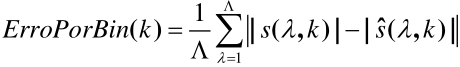

In [45]:
# Seria o erro por bin
def error_by_bin(frames_ref: list, frames_est: list, k_bin: int) -> float:
    """ """
    bin_error = 0
    n_frames = len(frames_ref) 
    
    for frame in range(n_frames):
        est_frame = frames_ref[frame]
        ref_frame = frames_ss[frame]
        frame_error = spectrum_error_signal(ref_frame, est_frame)
        bin_error += frame_error[k_bin]
    
    mean_bin_error = bin_error / n_frames    
    
    return mean_bin_error

In [51]:
bin_error = error_by_bin(frames_rr, frames_ss, 200)

print(f'Bin Error: {bin_error:.2f}')

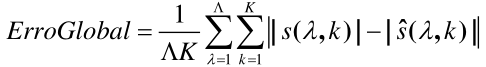

In [55]:
# Erro Global
def global_error(frames_ref: list, frames_est: list) -> float:
    """ """
    global_error = 0
    n_frames = len(frames_ref)
    n_bins = len(frames_ref[0])
    ratio = n_frames * n_bins
    
    for n_frame in range(len(frames_ref)):
        est_frame = frames_ref[n_frame]
        ref_frame = frames_ss[n_frame]
        frame_error = spectrum_error_signal(ref_frame, est_frame)
        global_error += sum(frame_error)
    
    mean_global_error = global_error / ratio
    
    return mean_global_error

In [56]:
global_error = global_error(frames_rr, frames_ss)
print(f'Bin Error: {global_error:.2f}')

Bin Error: 0.04
